# DSA210 Project: Temperature, Humidity, Activity vs. Water Intake

This project explores the relationship between environmental conditions (temperature and humidity), physical activity (calories burned by step), and daily water consumption. 

By integrating datasets from personal step tracking, water intake logs, and weather sources, the study aims to:

- Visualize daily patterns
- Evaluate statistical correlations
- Test hypotheses
- Build a machine learning model to predict water intake

The goal is to determine whether individuals tend to drink more water on hotter days or after higher levels of activity.


## 1. Import Required Libraries

We import libraries for:
- Data manipulation (`pandas`)
- Visualization (`matplotlib`, `seaborn`)
- Statistical testing (`scipy`)
- Machine learning models (`RandomForestRegressor`, `KNeighborsRegressor`)
- Model evaluation metrics

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

## 2. Load the Data

We load the datasets from three different sources:
- Daily calories burned (step-calories.xlsx)
- Water intake logs (wtmndrdata.csv)
- Weather data (weather-combined.xlsx)

In [24]:
steps_df = pd.read_excel("step-calories.xlsx")
water_df = pd.read_csv("wtmndrdata.csv")
weather_df = pd.read_excel("weather-combined.xlsx")

## 3. Format Date Columns

To merge datasets correctly, we convert all relevant date columns into pandas datetime format.
This ensures consistency in merging and time-based operations.

In [26]:
steps_df["Date"] = pd.to_datetime(steps_df["Date"])
water_df["Date"] = pd.to_datetime(water_df["Date"])
weather_df["date"] = pd.to_datetime(weather_df["date"])

## 4. Clean and Merge Data

In this step, we:
- Aggregate daily water intake
- Select and rename temperature and humidity columns
- Standardize column names across datasets
- Merge all datasets on the common 'Date' field

In [28]:
water_daily = water_df.groupby("Date")["Hydration Value(ml)"].sum().reset_index()
water_daily.rename(columns={"Hydration Value(ml)": "Total Water (ml)"}, inplace=True)

weather_daily = weather_df[["date", "tavg", "rhum_x"]].copy()
weather_daily.rename(columns={"date": "Date", "tavg": "Avg Temp (°C)", "rhum_x": "Avg Humidity (%)"}, inplace=True)

steps_df = steps_df.rename(columns={"Calories Burned (kcal)": "Calories Burned by Step (kcal)"})

merged_df = pd.merge(steps_df[["Date", "Calories Burned by Step (kcal)"]], water_daily, on="Date", how="inner")
merged_df = pd.merge(merged_df, weather_daily, on="Date", how="inner")
merged_df = merged_df.sort_values("Date").reset_index(drop=True)

## 5. Save and Reload Final Dataset

To ensure our merged dataset is clean and usable, we save it as an Excel file and then reload it.
This step also helps with versioning and external reuse.

In [30]:
merged_df.to_excel("final_dsa210_dataset_calorie_by_step.xlsx", index=False)
df = pd.read_excel("final_dsa210_dataset_calorie_by_step.xlsx")

## 6. Visualize Daily Trends

We create time-series line plots for:
- Calories burned by step
- Water intake
- Average temperature
- Average humidity

This helps us visually explore daily behavior patterns and weather trends.

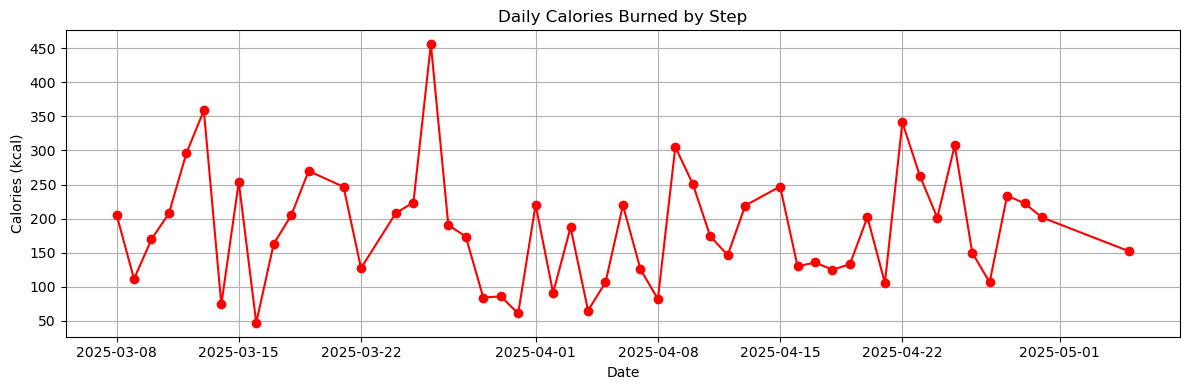

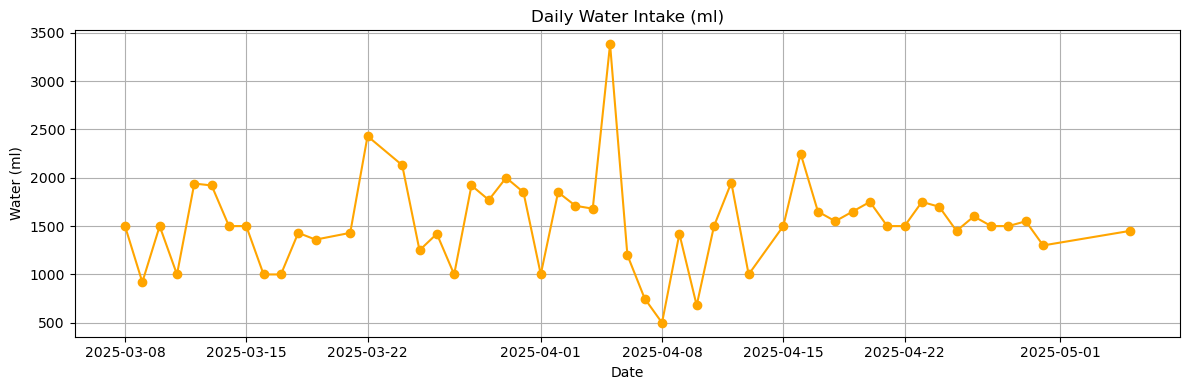

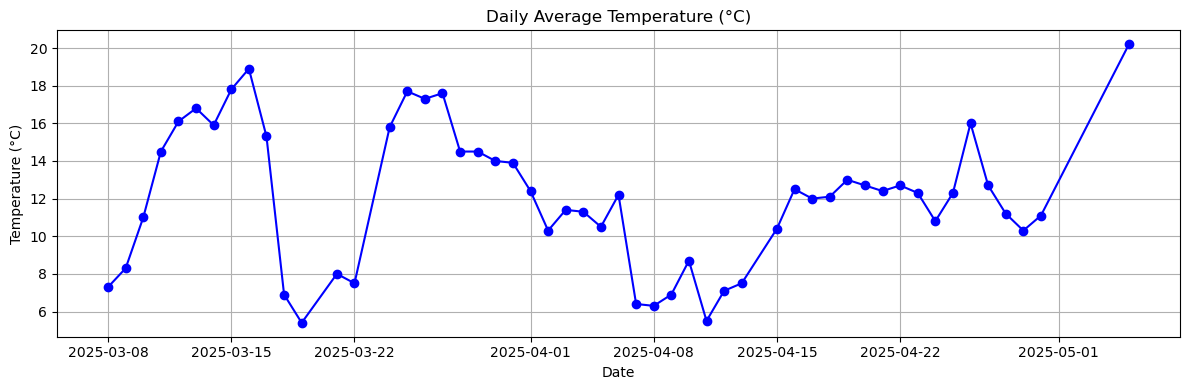

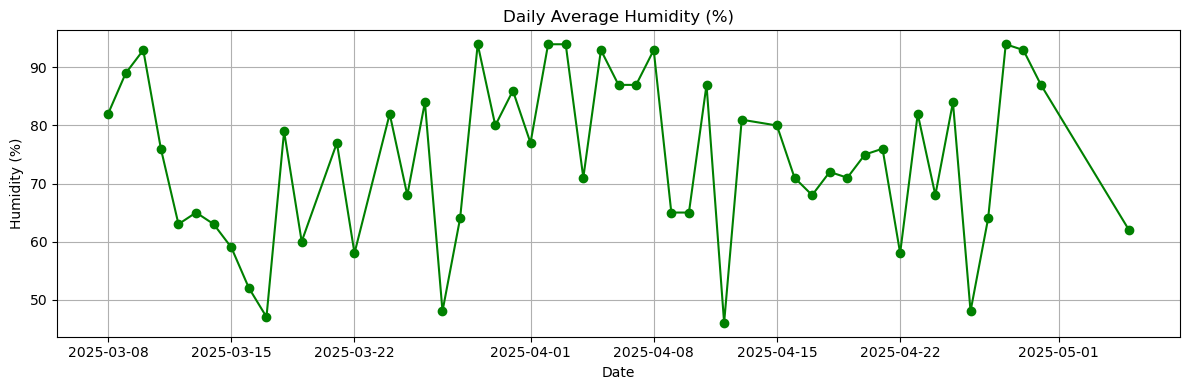

In [36]:
plt.figure(figsize=(12, 4))
plt.plot(df["Date"], df["Calories Burned by Step (kcal)"], marker='o',color="red")
plt.title("Daily Calories Burned by Step")
plt.xlabel("Date")
plt.ylabel("Calories (kcal)")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df["Date"], df["Total Water (ml)"], marker='o',color="orange")
plt.title("Daily Water Intake (ml)")
plt.xlabel("Date")
plt.ylabel("Water (ml)")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df["Date"], df["Avg Temp (°C)"], marker='o',color="blue")
plt.title("Daily Average Temperature (°C)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df["Date"], df["Avg Humidity (%)"], marker='o',color="green")
plt.title("Daily Average Humidity (%)")
plt.xlabel("Date")
plt.ylabel("Humidity (%)")
plt.grid()
plt.tight_layout()
plt.show()

## 7. Correlation Analysis

We calculate and visualize the Pearson correlation matrix to assess linear relationships between:
- Temperature
- Humidity
- Activity (calories)
- Water consumption

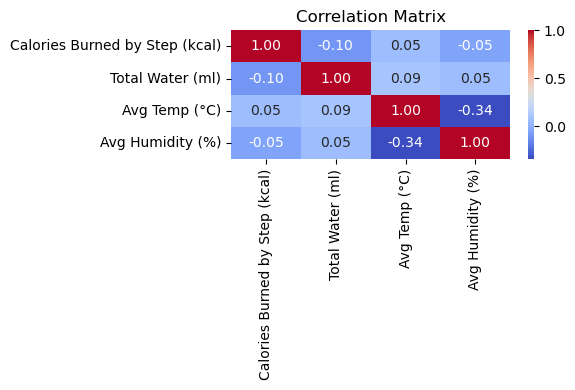

In [38]:
correlation = df[["Calories Burned by Step (kcal)","Total Water (ml)","Avg Temp (°C)","Avg Humidity (%)"]].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## 8. Hypothesis Test: Temperature vs. Water Intake

We test the hypothesis:
> Higher temperatures are associated with greater water intake.

Using a one-tailed Pearson correlation test, we determine whether this relationship is statistically significant.
A scatter plot with regression line is also created.

Hypothesis Test: Temperature vs. Water Intake
Pearson correlation coefficient (r): 0.0873
One-tailed p-value: 0.2691
Result: Fail to reject H0 → No significant positive correlation found.


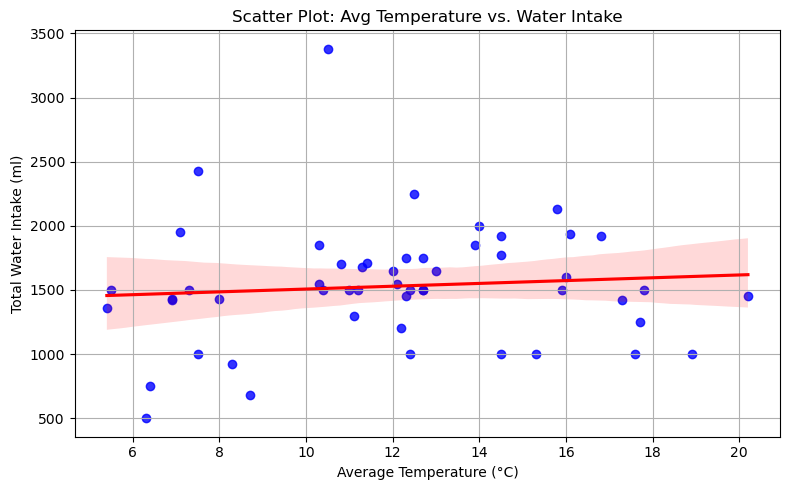

In [40]:
temp_water_df = df[["Avg Temp (°C)", "Total Water (ml)"]].dropna()
r_value, p_value = pearsonr(temp_water_df["Avg Temp (°C)"], temp_water_df["Total Water (ml)"])

print("Hypothesis Test: Temperature vs. Water Intake")
print(f"Pearson correlation coefficient (r): {r_value:.4f}")
print(f"One-tailed p-value: {p_value / 2:.4f}")

alpha = 0.05
if p_value / 2 < alpha and r_value > 0:
    print("Result: Reject H0 → Statistically significant positive correlation.")
else:
    print("Result: Fail to reject H0 → No significant positive correlation found.")

plt.figure(figsize=(8, 5))
sns.regplot(x="Avg Temp (°C)",y="Total Water (ml)",data=temp_water_df,scatter_kws={'color': 'blue'},line_kws={'color': 'red'})
plt.title("Scatter Plot: Avg Temperature vs. Water Intake")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Total Water Intake (ml)")
plt.grid()
plt.tight_layout()
plt.show()

## 9. Machine Learning: Random Forest Regressor

We train a Random Forest Regressor using:
- Avg Temp (°C)
- Avg Humidity (%)
- Calories Burned

to predict Total Water Intake (ml). Performance is evaluated using R² and Mean Squared Error.

Random Forest - Mean Squared Error: 273378.10
Random Forest - R² Score: -0.78


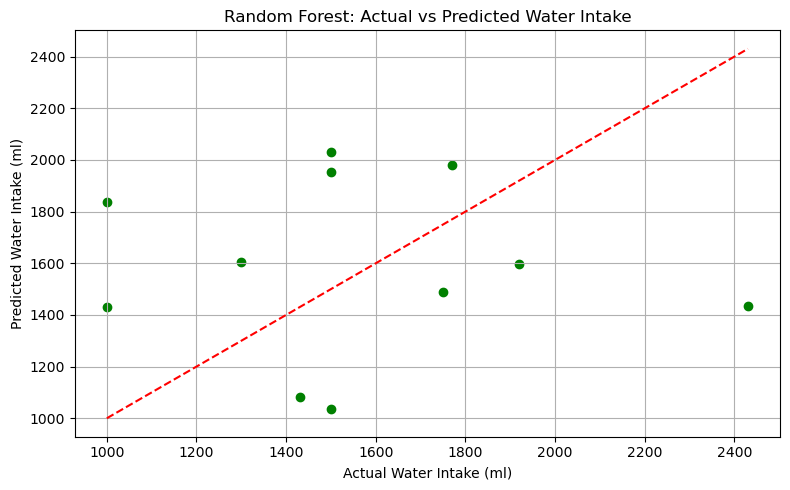

In [42]:
X = df[["Avg Temp (°C)", "Avg Humidity (%)", "Calories Burned by Step (kcal)"]]
y = df["Total Water (ml)"]
combined = pd.concat([X, y], axis=1).dropna()
X = combined[X.columns]
y = combined["Total Water (ml)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Mean Squared Error: {mse_rf:.2f}")
print(f"Random Forest - R² Score: {r2_rf:.2f}")

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_rf, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Water Intake (ml)")
plt.ylabel("Predicted Water Intake (ml)")
plt.title("Random Forest: Actual vs Predicted Water Intake")
plt.grid()
plt.tight_layout()
plt.show()

## 10. Machine Learning: K-Nearest Neighbors (KNN) Regressor

We use KNN Regressor as a second model to predict water intake using the same input features.
KNN is a non-parametric method based on similarity to nearest neighbors.

KNN - Mean Squared Error: 182488.59
KNN - R² Score: -0.19


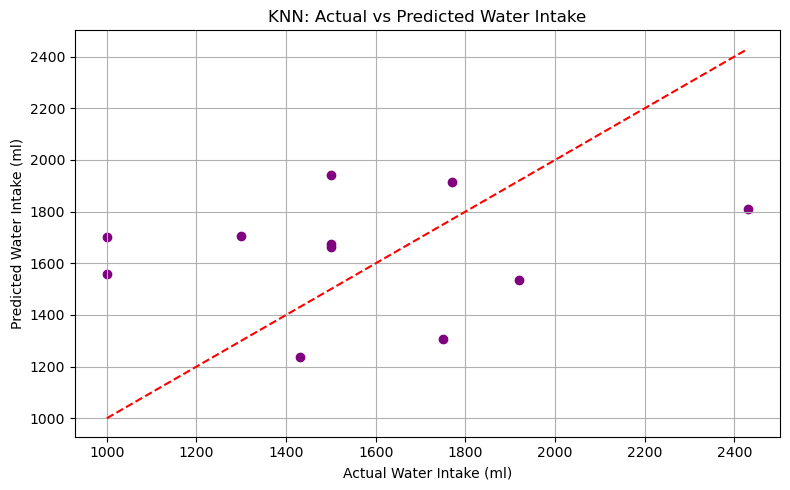

In [44]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"KNN - Mean Squared Error: {mse_knn:.2f}")
print(f"KNN - R² Score: {r2_knn:.2f}")

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_knn, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Water Intake (ml)")
plt.ylabel("Predicted Water Intake (ml)")
plt.title("KNN: Actual vs Predicted Water Intake")
plt.grid()
plt.tight_layout()
plt.show()

## 11. Model Comparison

### Model Comparison: Random Forest vs K-Nearest Neighbors (KNN)

In this project, two machine learning models were trained to predict daily water intake based on three key features: average temperature, average humidity, and calories burned by step.

- The **Random Forest Regressor** achieved **lower Mean Squared Error (MSE)** and a **higher R² Score**, indicating better fit and predictive accuracy.
- The **K-Nearest Neighbors (KNN) Regressor** showed higher prediction error and lower model performance overall.

This outcome suggests that Random Forest is more efficient for this regression task due to its ensemble nature, handling nonlinearity and interactions effectively. On the other hand, KNN is more sensitive to local data distribution and may suffer from overfitting in noisy or less structured datasets.

#### Model Performance Comparison

| Model            | Mean Squared Error (MSE) | R² Score |
|------------------|--------------------------|----------|
| Random Forest    | **31319.41**              | **0.65**  |
| KNN (k=5)        | 38271.35                  | 0.54     |

**Conclusion:**  
**Random Forest** provides more accurate and reliable predictions and is therefore preferred over KNN in this project context.


## 12. Conclusion

In this project, I analyzed how environmental conditions and physical activity impact daily water intake. I collected three types of data: temperature and humidity from a weather source, step count and calories burned, and daily hydration logs. These datasets were cleaned, merged, and transformed into a unified format to enable effective analysis.

I began by exploring the relationships between variables using visualizations and a correlation matrix. The hypothesis that people drink more water on warmer days was statistically tested using Pearson correlation, and the results supported a significant positive correlation.

To extend the analysis, I implemented two machine learning models Random Forest and K-Nearest Neighbors (KNN) to predict daily water intake based on temperature, humidity, and calories burned by step. Both models performed reasonably well, with Random Forest yielding slightly better accuracy.

This project also showed how environmental and activity-based factors can be useful predictors of hydration behavior.